# ICFO Challenge: QUANTUM SIMULATION WITH QUANTUM COMPUTERS

Barcelona, April 1-2, 2023

&nbsp;

---

_Greetings, brave heroes! Welcome to the **Qiskit Hackathon Barcelona**._

_Unlike the latest blockbuster on the cinemas right now, the challenges you shall face here are no "mania" jokes.
The nuclear core in our hidden research facilities is destabilized.
Your elite team will venture into the core of our underground advanced lab to deal with this emergency situation (or die trying).
We estimate a maximum of 24h before it collapses and the radioactive debris ruin the world's surface.
Should you succeed, we'll all be safe and you'll be rewarded with great honour.
Should you fail, it'll all be lost!
But fear not, as the power of real quantum computers will be at your fingertips, allowing you to run actual lab experiments on remote IBM Q processors.
With great teamwork no challenge will remain unbeaten._

_The evacuation is nearly complete and most of the big-shots are already heading towards their space shuttles.
Yes, this is the dimension of the potential catastrophe. No pressure, though.
As you head down the facility, contention gates keep shutting down behind you.
At the bottom, you encounter your first challenge: the contention gate leading to the core has already been sealed in what looks like a futile and desperate attempt to contain the disaster._

_The breaching expert in the team gets to work.
However, bypassing this security gate seems more cumbersome than expected.
Just as she seems completely out of options, a wild idea crosses her mind: if you knew the magnetic properties of the security system's board, she would have the perfect tool to alter them and break the gate open._

---

# CONTENTS <a class="anchor" id="0"></a>

* [1. SPINS IN THE GROUND-STATE: THE XXZ HEISENBERG MODEL](#1)
* [2. FERMIONS IN EXCITED STATES: THE LITHIUM HYDRATE MOLECULE](#2)
* [3. MASTER THE QUANTUM SIMULATION SHENANIGANS](#3)
* [REFERENCES](#REF)

---

# 1. SPINS IN THE GROUND STATE: THE XXZ HEISENBERG MODEL <a class="anchor" id="1"></a> [[↑]](#0)

_The quantum physicist in your unit, Seedis, gets to work.
He kneels down and opens the heavy backpack he's been carrying.
It's an actual quantum computer.
"Let's simulate the hell out of it! What're you lookin' at? Chop chop. There's no time to waste!"_

> In this first task, you will study a spin system, a prototypical problem in condensed matter physics. You will find that spins can manifest different phases and behaviours even when they rest at their ground state.

To simulate a quantum system, we need to determine the interactions between the quantum particles that constitute it by defining its Hamiltonian operator.
The security system's board contains rings that follow the XXZ Heisenberg model [[Ref.1]](#REF)<a class="anchor" id="Ref1"></a>, given by

$$ H_{XXZ} = -\frac{1}{4}\sum_{i=1}^N \sigma_i^x\sigma_{i+1}^x + \sigma_i^y\sigma_{i+1}^y + \Delta \, \sigma_i^z\sigma_{i+1}^z \,.$$

Here, $N$ is the number of spin-1/2 particles, $\Delta$ is the anisotropy parameter, and $\sigma^x_i$, $\sigma^y_i$, and $\sigma^z_i$ are Pauli operators, where the subscripts label the qubit they act on.
Furthermore, we impose the periodic boundary condition $\sigma^u_{i+N}=\sigma^u_{i}$ to make the object rest on a ring shape.
Note that only qubits next to each other interact.

This model captures a rich range of behaviours throughout its phase diagram.
First off, for $\Delta=1$, the model converges to the isotropic Heisenberg Hamiltonian (XXX), where all the terms have the same coupling strength.
As we vary $\Delta$, the system can be in three phases:

- $\Delta> 1$: the **ferromagnetic** phase, where all spins point in the same direction.
- $-1<\Delta<1$: the **paramagnetic** or critical phase, where the spins are completely disordered.
- $\Delta<-1$: the **anti-ferromagnetic** phase, where neighboring spins are anti-aligned.

We consider $N=12$ for all the calculations throughout this task, and vary $\Delta$ to see different physics.

## 1.1 - Ground state energy of the XXZ model

Quantum systems can be naturally found in their ground state (GS). 
Thus, the first step is to learn to prepare GSs with the quantum computer.
A prominent approach to do so is through the **Variational Quantum Eigensolver (VQE)** algorithm [[Ref. 2]](#REF)<a class="anchor" id="Ref2"></a>.

Interestingly, the energy spectrum of the $H_{XXZ}$ model can be obtained analytically using the _Bethe ansatz_. For $\Delta>1$, the system is in the _ferromagnetic phase_, in which all the spins in the GS point towards the same direction. This GS energy $\epsilon_{GS}$ is known to be:

$$\epsilon_{GS}=-N\frac{\Delta}{4}\,.$$

### Prepare a simple $N$-qubit state to represent a GS wave function in the ferromagnetic phase. Compute its energy taking the expectation value of the Hamiltonian to confirm the theoretical result $\epsilon_{GS}$ for $\Delta=4$.

> Tip: Qiskit's Heisenberg model implementation already assumes the particles have spin 1/2 and, thus, you do not need to put the 1/4 prefactor in the Hamiltonian definition. Don't forget the sign though!

In [151]:
from qiskit_nature.second_q.hamiltonians.lattices import BoundaryCondition,LineLattice

from qiskit_nature.second_q.hamiltonians import HeisenbergModel

from qiskit_nature.second_q.mappers import QubitConverter, LogarithmicMapper

def heisenberg_model(num_nodes=12, delta=4):
    line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=BoundaryCondition.PERIODIC)
    heisenberg = HeisenbergModel(lattice=line_lattice, coupling_constants = (-1.0,-1.0,-delta))
    mapper = LogarithmicMapper()
    hamiltonian = heisenberg.second_q_op()
    converter = QubitConverter(mapper=mapper)
    return converter.convert(heisenberg.second_q_op())

In [234]:
import qiskit as qk
import numpy as np
    

def expected_value_nn(gate,shots=1000, num_nodes=12):
    """Function that calculates the sum of the expected values of the nearest neighbours for a given gate, 
    given periodic boundary conditions, and a ferromagnetic initial state.

    Args:
        gate (str): gate to be applied to the nearest neighbours. Can be 'X', 'Y' or 'Z'.
        shots (int, optional): Number of shots in the quantum machine (or simulator). Defaults to 1000.
        num_nodes (int, optional): Number of nodes in the circuit. Defaults to 12.

    Raises:
        ValueError: If the gate is not 'X', 'Y' or 'Z', the function raises a ValueError.

    Returns:
        float: Expected value of the nearest neighbours (for every nn pair) for the given gate.
    """    
    if gate == "X":
        sumatorium=[]
        for i in range(num_nodes):
            # Iterating over the nodes
            qubit_list=list(range(num_nodes))
            # Inicializate the initial state, as in the ferromagnetic phase, all the spins are pointing in the same direction
            circuit = QuantumCircuit(num_nodes,num_nodes)
            # Create X gates for the nearest neighbour of the node i
            if i<num_nodes-1:
                qubit_list.remove(i)
                qubit_list.remove(i+1)
                circuit.x(i)
                circuit.x(i+1)
            else:
                qubit_list.remove(1)
                qubit_list.remove(0)
                circuit.x(i)
                circuit.x(0)
            # Apply the identity to the rest of the qubits
            circuit.i(qubit_list)
            # Measure the qubits
            circuit.measure(range(12),range(12))
            simulator = qk.Aer.get_backend('qasm_simulator')
            # Execute the circuit and get the counts
            # A try-except is used to avoid errors when the state is not measured 
            # (for instance if we apply an X gate to the state |0> and we try to get the counts of the state |0>))
            try:
                result = qk.execute(circuit,backend=simulator,shots=shots).result().get_counts()['000000000000']
            except Exception:
                result=0
            # Normalize the counts to one and getting its square root
            sumatorium.append(np.sqrt(result/shots))
        return np.sum(sumatorium)
    
    # From here, the code is the same but just changing the gates
    
    elif gate == "Y":
        sumatorium=[]
        for i in range(num_nodes):
            qubit_list=list(range(num_nodes))
            circuit = QuantumCircuit(num_nodes,num_nodes)
            if i<num_nodes-1:
                qubit_list.remove(i)
                qubit_list.remove(i+1)
                circuit.y(i)
                circuit.y(i+1)
            else:
                qubit_list.remove(1)
                qubit_list.remove(0)
                circuit.y(i)
                circuit.y(0)
            circuit.i(qubit_list)
            circuit.measure(range(12),range(12))
            simulator = qk.Aer.get_backend('qasm_simulator')
            try:
                result = qk.execute(circuit,backend=simulator,shots=shots).result().get_counts()['000000000000']
            except Exception:
                result=0
            sumatorium.append(np.sqrt(result/shots))
        return np.sum(sumatorium)
    elif gate == "Z":
        sumatorium=[]
        for i in range(num_nodes):
            qubit_list=list(range(num_nodes))
            circuit = QuantumCircuit(num_nodes,num_nodes)
            if i<num_nodes-1:
                qubit_list.remove(i)
                qubit_list.remove(i+1)
                circuit.z(i)
                circuit.z(i+1)
            else:
                qubit_list.remove(1)
                qubit_list.remove(0)
                circuit.z(i)
                circuit.z(0)
            circuit.i(qubit_list)
            circuit.measure(range(12),range(12))
            simulator = qk.Aer.get_backend('qasm_simulator')
            try:
                result = qk.execute(circuit,backend=simulator,shots=shots).result().get_counts()['000000000000']
            except Exception:
                result=0
            sumatorium.append(np.sqrt(result/shots))
        return np.sum(sumatorium)
    else:
        raise ValueError("Gate not supported")

In [235]:
def ferromagnetic_eigenenergies(delta=4, num_shots=10, num_nodes=12):
    """Function that calculates the ferromagnetic eigenenergies for the heisenberg model.

    Args:
        delta (int, optional): Delta parameter of the Heisenberg model. Defaults to 4.
        num_shots (int, optional): Number of shots. Defaults to 10.

    Returns:
        float: Expected value of the ferromagnetic eigenenergies of the Heisenberg model.
    """
    if delta<1:
        raise ValueError("Delta must be greater than 1 for the model to work, as the initial state is ferromagnetic")
    x=expected_value_nn("X",num_shots, num_nodes)
    y=expected_value_nn("Y",num_shots, num_nodes)
    z=expected_value_nn("Z",num_shots, num_nodes)
    return -1/4*(x+y+delta*z)

In [236]:
N=12
delta=4

hamiltonian_expected_value = ferromagnetic_eigenenergies(delta=delta, num_shots=1000, num_nodes=N)

exact_eigenergy = -N*delta/4

print(f"Exact eigenenergy: {exact_eigenergy}, hamiltonian expected value: {hamiltonian_expected_value}")

Exact eigenenergy: -12.0, hamiltonian expected value: -12.0


State preparation is not always that straightforward.
In the _anti-ferromagmetic phase_ (for $\Delta<-1$), the GS wave function is more difficult to prepare, as it consists of a non-trivial superposition of the computational basis states.

In the VQE algorithm, we use a parameterized circuit to prepare the GS of our Hamiltonian.
We start with an initial guess of the circuit parameters and optimize them to minimize the expectation value of the Hamiltonian.
This naturally brings us (close) to the GS of the system, as it is, by definition, the state with the lowest energy.

Before diving into state preparation with VQE, create a baseline to evaluate the variational results.

### Use an exact numerical solver to obtain the GS energy for $\Delta=-2$

In [240]:
heisenberg_hamiltonian = heisenberg_model(num_nodes=12, delta=4)
numpy_solver = NumPyMinimumEigensolver() 
result=numpy_solver.compute_minimum_eigenvalue(heisenberg_hamiltonian)
ground_state_energy = result.eigenvalue.real
print(f"Ground state energy: {ground_state_energy:.2f}")

Ground state energy: -12.00


In [160]:
heisenberg_hamiltonian = heisenberg_model(num_nodes=12, delta=-2)
numpy_solver = NumPyMinimumEigensolver() 
result=numpy_solver.compute_minimum_eigenvalue(heisenberg_hamiltonian)
ground_state_energy = result.eigenvalue.real
print(f"Ground state energy: {ground_state_energy:.2f}")

Ground state energy: -7.46


###### Alternative solution

In [164]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.quantum_info.operators import Operator, Pauli

delta=-2

operatorx = Operator(Pauli('XXIIIIIIIIII'))+Operator(Pauli('IXXIIIIIIIII'))+Operator(Pauli('IIXXIIIIIIII'))+Operator(Pauli('IIIXXIIIIIII'))+Operator(Pauli('IIIIXXIIIIII'))+Operator(Pauli('IIIIIXXIIIII'))+Operator(Pauli('IIIIIIXXIIII'))+Operator(Pauli('IIIIIIIXXIII'))+Operator(Pauli('IIIIIIIIXXII'))+Operator(Pauli('IIIIIIIIIXXI'))+Operator(Pauli('IIIIIIIIIIXX'))+Operator(Pauli('XIIIIIIIIIIX'))
operatory = Operator(Pauli('YYIIIIIIIIII'))+Operator(Pauli('IYYIIIIIIIII'))+Operator(Pauli('IIYYIIIIIIII'))+Operator(Pauli('IIIYYIIIIIII'))+Operator(Pauli('IIIIYYIIIIII'))+Operator(Pauli('IIIIIYYIIIII'))+Operator(Pauli('IIIIIIYYIIII'))+Operator(Pauli('IIIIIIIYYIII'))+Operator(Pauli('IIIIIIIIYYII'))+Operator(Pauli('IIIIIIIIIYYI'))+Operator(Pauli('IIIIIIIIIIYY'))+Operator(Pauli('YIIIIIIIIIIY'))
operatorz = Operator(Pauli('ZZIIIIIIIIII'))+Operator(Pauli('IZZIIIIIIIII'))+Operator(Pauli('IIZZIIIIIIII'))+Operator(Pauli('IIIZZIIIIIII'))+Operator(Pauli('IIIIZZIIIIII'))+Operator(Pauli('IIIIIZZIIIII'))+Operator(Pauli('IIIIIIZZIIII'))+Operator(Pauli('IIIIIIIZZIII'))+Operator(Pauli('IIIIIIIIZZII'))+Operator(Pauli('IIIIIIIIIZZI'))+Operator(Pauli('IIIIIIIIIIZZ'))+Operator(Pauli('ZIIIIIIIIIIZ'))

operador=-1/4*(operatorx+operatory+delta*operatorz)
numpy_solver = NumPyMinimumEigensolver() 
result=numpy_solver.compute_minimum_eigenvalue(operador)


print(f"Ground state energy: {result.eigenvalue:.2f}")

Ground state energy: -7.46


Use the VQE algorithm to prepare the GS of the Hamiltonian for the same value of $\Delta$.
You should try to achieve the closest estimate to the actual GS energy using an **ansatz consisting of three layers of single- and two-qubit gates, where two-qubit gates connect only near neighbor qubits**.
Furthermore, among the different possibilities for the optimizers that you can choose from, use the **Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html)) optimizer**.

### Use the VQE algorithm to estimate the GS energy for $\Delta=-2$

In [163]:
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils import algorithm_globals
from qiskit.primitives import Estimator


# Define the number of qubits and the type of rotations you want to use
num_qubits = 12
rotation_blocks = ["rx"]
entanglement_blocks = 'cz'
entanglement = 'circular'

# Define the number of layers for the ansatz
num_layers = 3

delta = -2
maxiter = 100

# Create the TwoLocal ansatz circuit
ansatz_Heisemberg = TwoLocal(
    num_qubits,
    rotation_blocks=rotation_blocks,
    entanglement_blocks=entanglement_blocks,
    entanglement=entanglement,
    reps=num_layers,
    insert_barriers=True
)

spsa = SPSA(maxiter = maxiter)

estimator = Estimator()
seed = 50
algorithm_globals.random_seed = seed
vqe = VQE(estimator = estimator, ansatz=ansatz_Heisemberg,optimizer = spsa)

heisenberg_hamiltonian = heisenberg_model(num_nodes=num_qubits, delta=delta)

result = vqe.compute_minimum_eigenvalue(operator = heisenberg_hamiltonian)

print(f"Ground State eigenenergy with the VQE: {result.eigenvalue:.2f}")

Ground State eigenenergy with the VQE: -5.15


## 1.2 - Ansatz expressibility

This method has several aspects that can be tuned, such as the shape of the ansatz or the optimization algorithm to find the parameters. These are important factors in more elaborate quantum simulations.
To better understand the role of these parameters, re-implement the method to solve the previous problem ($H_{XXZ}$ with $\Delta=-2$) and compare the results obtained with with different combinations of ansatze and classical optimizers.

 - **Ansatz**:
 
   - Alternating single- and two-qubit (controlled-Z) gate layers, with interactions between all qubit pairs in the two-qubit layers;
   - Alternating single- and two-qubit (controlled-Z) gate layers, in which two-qubit gates are applied only between neighbouring qubits.

 - **Optimizers**:
 
   - Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html));
   - Constrained Optimization By Linear Approximation ([COBYLA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html));
   - Sequential Least SQuares Programming ([SLSQP](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SLSQP.html)).

For both types of ansatze above, fix only 3 layers of each type of gate. Compare the 6 different combinations of ansatz and optimizer to understand which one performs better both in terms of the accuracy error obtained, and the time and number of steps to converge.

### Plot the estimate of the GS energy as a function of the optimization steps for all the combinations of optimizer and ansatz listed above.

In [231]:
def vqe_counts(entanglement,optimiser,delta=-2):
    """Function that calculates the counts and values for each step of the VQE algorithm and returns them and the result in a tuple

    Args:
        entanglement (str): topology of the entanglement
        optimiser (str): Optimizer to use
        delta (int, optional): Delta value of the heisenberg model. Defaults to -2.

    Returns:
        tuple(list,list,VQEResult): Tuple containing the counts and values for each step of the VQE algorithm and the result of the VQE algorithm
    """    
    valid_entanglements = ['circular', 'full']
    valid_optimizers = ["SPSA","SLSQP","COBYLA"]
    if entanglement not in valid_entanglements:
        raise ValueError(f"Entanglement must be one of {valid_entanglements}")
    if optimiser not in valid_optimizers:
        raise ValueError(f"Optimizer must be one of {valid_optimizers}")
    
    # Define the number of qubits and the type of rotations you want to use
    num_qubits = 12
    rotation_blocks = ["rx"]
    entanglement_blocks = 'cz'

    # Define the number of layers for the ansatz
    num_layers = 3

    # Create the TwoLocal ansatz circuit
    ansatz_Heisemberg = TwoLocal(
        num_qubits,
        rotation_blocks=rotation_blocks,
        entanglement_blocks=entanglement_blocks,
        entanglement=entanglement,
        reps=num_layers,
        insert_barriers=True
    )
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    estimator = Estimator()
    seed = 50
    algorithm_globals.random_seed = seed
    vqe = VQE(estimator = estimator, ansatz=ansatz_Heisemberg,optimizer = optimiser,callback = store_intermediate_result)
    # Define the heisenberg model
    heisenberg_hamiltonian = heisenberg_model(num_nodes=num_qubits, delta=delta)
    result = vqe.compute_minimum_eigenvalue(operator = heisenberg_hamiltonian)
    return values,counts,result

After some tests, we saw that the next `maxiter` values for the diferent optimizers, works the best

In [208]:
import pandas as pd
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA
maxiter=250
maxiter_cobyla=4000

entanglement_options = ["full","circular"]
optimizers = [SPSA(maxiter=maxiter),SLSQP(maxiter=maxiter),COBYLA(maxiter=maxiter_cobyla)]
dataframes = []
for entanglement in entanglement_options:
    k=0
    for optimizer in optimizers:
        k=k+1
        values,counts,_ = vqe_counts(entanglement,optimizer)
        dataframes.append(pd.DataFrame({f'values{entanglement}{k}':values,f'counts{entanglement}{k}':counts}))

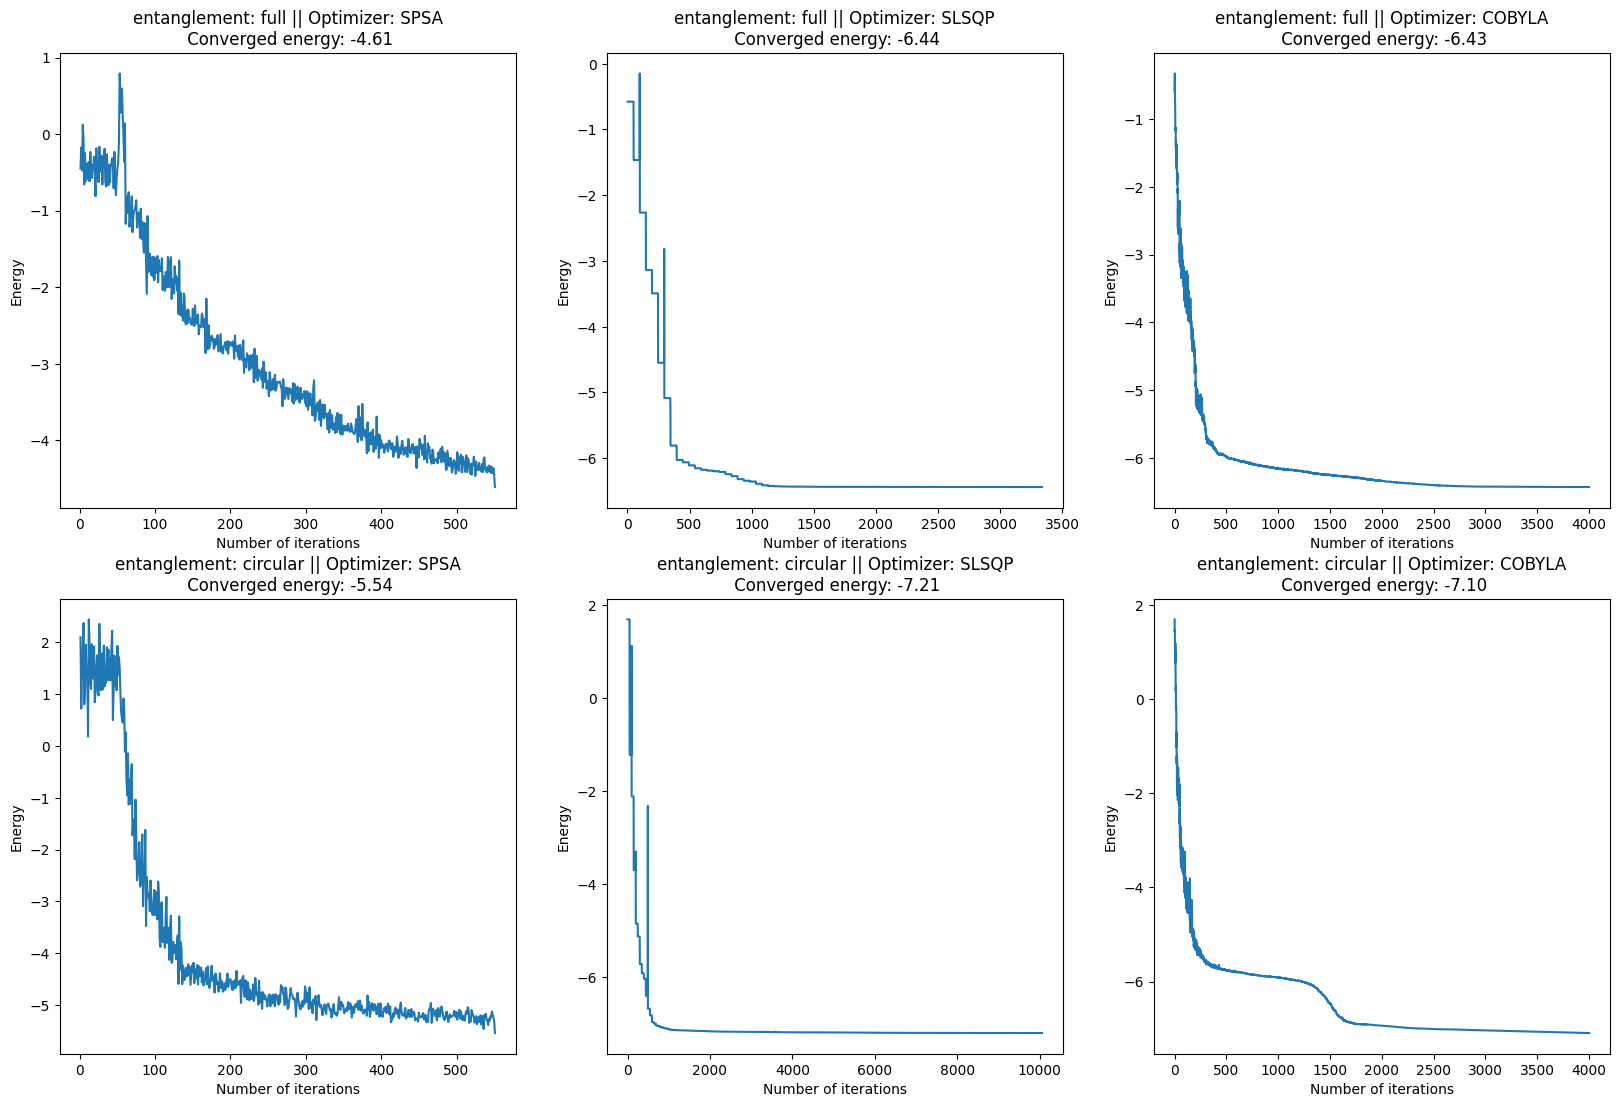

In [230]:
import matplotlib.pyplot as plt
optimizer_names = ["SPSA","SLSQP","COBYLA"]
fig, ax = plt.subplots(2,3,figsize=(20,13))
for i in range(6):
    file_name="full"
    k=i+1
    if i>2:
        file_name="circular"
        k=i-2
    plt.subplot(2,3,i+1)
    plt.plot(dataframes[i][f'counts{file_name}{k}'],dataframes[i][f'values{file_name}{k}'])
    plt.xlabel("Number of iterations")
    plt.ylabel("Energy")
    string = f"{dataframes[i][f'values{file_name}{k}'].values[-1]:.2f}"
    plt.title(f'entanglement: {file_name} || Optimizer: {optimizer_names[k-1]}\n Converged energy: {string}')



As we see, the `COBYLA` optimizer with the `circular` entanglement topology is the one that converges faster (in time) and at arround 2500 iterations, we have a good expected value

## 1.3 - Phase diagram

As we have introduced above, the full phase diagram of the $H_{XXZ}$ model encompasses a rich range of behaviours:

- For $\Delta>1$, we have a **ferromagnetic** phase.
- For $-1<\Delta<1$, we have a **paramagnetic** phase.
- For $\Delta\leq-1$, we have an **anti-ferromagnetic** phase.

Use the best combination of optimizer and ansatz that you have found before to prepare the GS of the system for different values of $\Delta$ to reconstruct the phase diagram.
Consider, at least, the values of $\Delta=\{-2, -1, 0, 1, 2\}$.
These will allow you to probe the properties of the GS in each phase.
If you can afford to use more points within the $\Delta\in[-2, 2]$ range, go for it!

Taking the exact solution as a reference, try to improve the ansatz, e.g., adding more layers, to obtain a better representation of the GS of the system.

Once you find the optimal parameters for your best ansatz, use it to compute the expectation value of the **magnetization** of the system along the $z$-axis
$$
M \equiv \frac{1}{2N} \sum_{i=1}^{N} \left\langle \sigma_{i}^{z} \right\rangle\,,
$$
the **staggered magnetization**
$$
M_{st} \equiv \frac{1}{2N}\sum_{i=1}^N (-1)^i\left\langle\sigma_i^z\right\rangle\,,
$$
as well as the expectation value of the **nearest neighbour correlator**
$$
C \equiv \frac{1}{4N} \sum_{i=1}^{N}\left\langle \sigma_{i}^{z} \sigma_{i+1}^{z}  \right\rangle\,.
$$
Plot these observables as a function of $\Delta$.
You will need to prepare the GS multiple times to estimate these averages from the measurement statistics.

### Plot $M$, $M_{st}$ and $C$ as a function of $\Delta$ and comment on the GS properties you can infer from these observables.
> Tip: If you find degenerate GSs, you can compute the expectation values above with only one of them (manually break the symmetry).
Alternatively, you can try to energetically favour one of those by adding an external magnetic field in one direction in the Hamiltonian $H_{XXZ} + \delta\sigma_0^z$ with small $\delta$.

#### Energies

In [246]:
import matplotlib.pyplot as plt
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA

from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import Estimator
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

from qiskit_nature.second_q.hamiltonians import (
    HeisenbergModel,
)

from qiskit_nature.second_q.mappers import  QubitConverter, LogarithmicMapper


def vqe_instancer(entanglement,optimiser,delta):
    # Define the number of qubits and the type of rotations you want to use
    num_qubits = 12
    rotation_blocks = ["rx"]
    entanglement_blocks = 'cz'
    entanglement = entanglement
    #full

    # Define the number of layers for the ansatz
    num_layers = 3

    # Create the TwoLocal ansatz circuit
    ansatz_Heisemberg = TwoLocal(
        num_qubits,
        rotation_blocks=rotation_blocks,
        entanglement_blocks=entanglement_blocks,
        entanglement=entanglement,
        reps=num_layers,
        insert_barriers=True
    )

    estimator = Estimator()
    seed = 50
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(Aer.get_backend('qasm_simulator'))
    vqe = VQE(estimator = estimator, ansatz=ansatz_Heisemberg,optimizer = optimiser)
    

    heisenberg_op = heisenberg_model(delta=delta)
    

    result = vqe.compute_minimum_eigenvalue(operator = heisenberg_op)


    return result

maxiter=4000
delta_list=[-2,-1,0,1,2]
entanglement_options = ["full","circular"]
optimizers = [SPSA(maxiter=maxiter),SLSQP(maxiter=maxiter),COBYLA(maxiter=maxiter)]

# We compute now the exact solution to compare the VQE with the exact solution

results_list = []
for delta in delta_list:
    print(delta)
    result_vqe = vqe_instancer(entanglement_options[1],optimizers[2],delta)

    heisenberg_hamiltonian = heisenberg_model(delta=delta)
    numpy_solver = NumPyMinimumEigensolver() 
    result=numpy_solver.compute_minimum_eigenvalue(heisenberg_hamiltonian)
    exact_e = result.eigenvalue.real
    results_list.append((result_vqe.eigenvalue,exact_e))

-2
-1
0
1
2


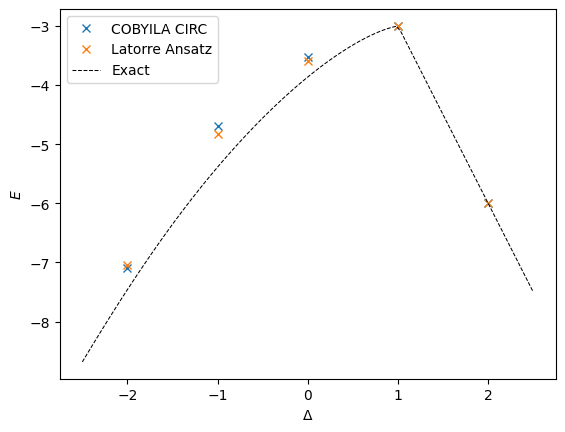

In [248]:
import math as math 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


#-------------------------------------------------------------------------------------


delta_list=[-2,-1,0,1,2]
E_list=[]
E_exact_list=[]

E_list=[results_list[i][0] for i in range(len(results_list))]
E_exact_list=[results_list[i][1] for i in range(len(results_list))]

# Plotting the VQE results
fig, gr_p=plt.subplots()
gr_p.set_xlabel(r'$\Delta$') 
gr_p.set_ylabel(r'$E$')
gr_p.plot(delta_list,E_list,linestyle="",marker="x",markersize=6,label='COBYILA CIRC')


delta_list=[]
E_list=[]

# This part of the code is the data with an ansatz that we found from Dr. Latorre. We can see that even that this one is better than the one we found,
# ours is still good enough to get the correct result.

outputFile=open("improve_own_ansatz_delta.dat","r",encoding='utf-8')
for line in outputFile.readlines()[:]: # The lines are read from the file
    # The line is stripped taking out all the unnecesary characters
    lineStripped = line.strip()
    # The line is splitted using the tab character
    lineSplitted = lineStripped.split('\t')
    delta_list.append(float(lineSplitted[0])) 
    E_list.append(float(lineSplitted[1]))
outputFile.close()
gr_p.plot(delta_list,E_list,linestyle="",marker="x",markersize=6,label='Latorre Ansatz')


# Plotting the exact solution
delta_list=np.linspace(-2.5,2.5,100)
exact_list=[]
for delta in delta_list: 
    line_lattice = LineLattice(num_nodes=12, boundary_condition=BoundaryCondition.PERIODIC)

    heisenberg = HeisenbergModel(lattice=line_lattice, coupling_constants = (-1.0,-1.0,-delta))

    mapper = LogarithmicMapper()
    converter = QubitConverter(mapper=mapper)
    hamiltonian = heisenberg.second_q_op()
    operator2 = converter.convert(hamiltonian)

    numpy_solver = NumPyMinimumEigensolver() 
    result=numpy_solver.compute_minimum_eigenvalue(operator2)
    exact_e = result.eigenvalue.real
    exact_list.append(exact_e)
    


gr_p.plot(delta_list,exact_list,linestyle="--",marker="",color='black',linewidth=0.75,markersize=4,label='Exact')


gr_p.legend(loc='best')
plt.show()

#### Redefinition of the ``Qiskit`` HesienbergModel 

In [252]:
from __future__ import annotations
from fractions import Fraction
import numpy as np
from qiskit_nature.second_q.operators import SpinOp

from qiskit_nature.second_q.hamiltonians.lattices import Lattice
from qiskit_nature.second_q.hamiltonians import LatticeModel


class HeisenbergModel2(LatticeModel):
    r"""The Heisenberg model.
    This class implements the following Hamiltonian:
    .. math::
        H = - \vec{J} \sum_{\langle i, j \rangle} \vec{\sigma}_{i} \otimes \vec{\sigma}_{j}
        - \vec{h} \sum_{i} \vec{\sigma}_{i}
    where :math:`i,j` refer to lattice nodes. The :math:`\sum_{\langle i, j \rangle}` is performed
    over adjacent lattice nodes. This model assumes spin-:math:`\frac{1}{2}` particles. Thus,
    :math:`\vec{\sigma}_{i} = (X_i, Y_i, Z_i)` is a vector containing the Pauli matrices.
    :math:`\vec{J}` is the coupling constant and :math:`\vec{h}` is the external magnetic field,
    both with dimensions of energy.
    This model is instantiated using a
    :class:`~qiskit_nature.second_q.hamiltonians.lattices.Lattice`. For example, using a
    :class:`~qiskit_nature.second_q.hamiltonians.lattices.LineLattice`:
    .. code-block:: python
        line_lattice = LineLattice(num_nodes=10, boundary_condition=BoundaryCondition.OPEN)
        heisenberg_model = HeisenbergModel(line_lattice, (1.0, 1.0, 1.0), (0.0, 0.0, 1.0))
    The transverse-field Ising model can be recovered as a special case of the Heisenberg model
    by limiting the model to spins that are parallel/antiparallel with respect to a transverse
    magnetic field:
    .. code-block:: python
        heisenberg_model = HeisenbergModel(line_lattice, (0.0, 0.0, 1.0), (1.0, 0.0, 0.0))
    """

    def __init__(
        self,
        lattice: Lattice,
        coupling_constants: tuple = (1.0, 1.0, 1.0),
        ext_magnetic_field: tuple = (0.0, 0.0, 0.0),
    ) -> None:
        """
        Args:
            lattice: Lattice on which the model is defined.
            coupling_constants: The coupling constants in each Cartesian axis.
                Defaults to ``(1.0, 1.0, 1.0)``.
            ext_magnetic_field: Represents a magnetic field in Cartesian coordinates.
                Defaults to ``(0.0, 0.0, 0.0)``.
        """
        super().__init__(lattice)
        self.coupling_constants = coupling_constants
        self.ext_magnetic_field = ext_magnetic_field

    @property
    def register_length(self) -> int:
        return self._lattice.num_nodes

    def second_q_op(self) -> SpinOp:
        """Return the Hamiltonian of the Heisenberg model in terms of ``SpinOp``.
        Returns:
            SpinOp: The Hamiltonian of the Heisenberg model.
        """
        hamiltonian = {}
        weighted_edge_list = self.lattice.weighted_edge_list
        i=0
        for node_a, node_b, _ in weighted_edge_list:

            if node_a == node_b:
                index = node_a
                for axis, coeff in zip("XYZ", self.ext_magnetic_field):
                    i+=1
                    if not np.isclose(coeff, 0.0):
                        if i%2==0:
                            coeff = -coeff
                        hamiltonian[f"{axis}_{index}"] = coeff
            else:
                index_left = node_a
                index_right = node_b
                for axis, coeff in zip("XYZ", self.coupling_constants):
                    i+=1
                    if not np.isclose(coeff, 0.0):
                        if i%2==0:
                            coeff = -coeff 
                        hamiltonian[f"{axis}_{index_left} {axis}_{index_right}"] = coeff       
        return SpinOp(hamiltonian, spin=Fraction(1, 2), num_spins=self.lattice.num_nodes)

#### Magnetization computation and plotting

In [249]:
def circ_func(entanglement,optimiser,delta):
    # Define the number of qubits and the type of rotations you want to use
    num_qubits = 12
    rotation_blocks = ["rx"]
    entanglement_blocks = 'cz'
    entanglement = entanglement
    #full

    # Define the number of layers for the ansatz
    num_layers = 3

    # Create the TwoLocal ansatz circuit
    ansatz_Heisemberg = TwoLocal(
        num_qubits,
        rotation_blocks=rotation_blocks,
        entanglement_blocks=entanglement_blocks,
        entanglement=entanglement,
        reps=num_layers,
        insert_barriers=True
    )
    # ansatz_Heisemberg.decompose().draw("mpl")
    spsa = SPSA(maxiter = 100)
    slsqp = SLSQP(maxiter = 100)

    estimator = Estimator()
    seed = 50
    algorithm_globals.random_seed = seed
 
    vqe = VQE(estimator = estimator, ansatz=ansatz_Heisemberg,optimizer = optimiser)
    

    line_lattice = LineLattice(num_nodes=12, boundary_condition=BoundaryCondition.PERIODIC)

    heisenberg = HeisenbergModel(lattice=line_lattice, coupling_constants = (-1.0,-1.0,-delta),ext_magnetic_field=(0,0,0.001))

    mapper = LogarithmicMapper()
    converter = QubitConverter(mapper=mapper)
    hamiltonian = heisenberg.second_q_op()
    hamiltonian1 = converter.convert(hamiltonian)
    
    heisenberg_magne = HeisenbergModel(lattice=line_lattice, coupling_constants = (0,0,0),ext_magnetic_field=(0,0,1))

    mapper = LogarithmicMapper()
    converter = QubitConverter(mapper=mapper)
    magne = heisenberg_magne.second_q_op()
    magne1 = converter.convert(magne)
    
    result1 = vqe.compute_minimum_eigenvalue(operator = hamiltonian1, aux_operators=[magne1])

    # vqe = VQE(ansatz_Heisemberg,optimizer = spsa)

    return result1

maxiter=4000
outputFile=open("M_delta.dat","w",encoding='utf-8')
delta_list=[-2,-1,0,1,2]
entanglement_options = ["full","circular"]
optimizers = [SPSA(maxiter=maxiter),SLSQP(maxiter=maxiter),COBYLA(maxiter=maxiter)]

# We compute now the exact solution to compare the VQE with the exact solution

result_list=[]
for delta in delta_list:
    print(delta)
    result1 = circ_func(entanglement_options[1],optimizers[2],delta)
    print(result1.aux_operators_evaluated)
    result_list.append(result1.aux_operators_evaluated[0][0])


-2
[(0.0006944011464519728, {})]
-1
[(-0.001728160831138803, {})]
0
[(-0.010724421109111277, {})]
1
[(4.4158199604350505, {})]
2
[(5.9999545905674765, {})]


Text(0, 0.5, '$M$')

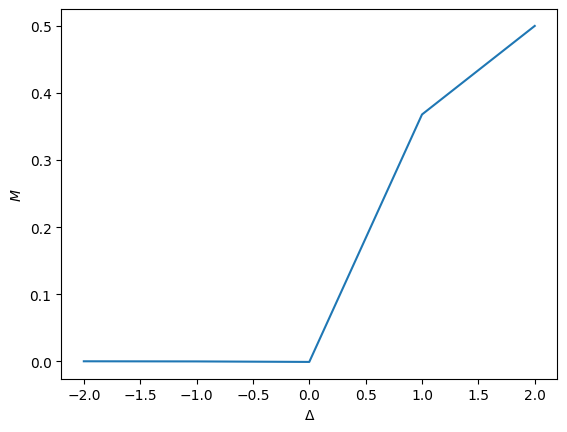

In [250]:
list1=[result_list[i]/12 for i in range(len(result_list))]
plt.plot([-2,-1,0,1,2],list1)
plt.xlabel("$\Delta$")
plt.ylabel("$M$")

#### Stagger magnetization computation and plotting

In [253]:
def circ_func(entanglement,optimiser,delta):
    # Define the number of qubits and the type of rotations you want to use
    num_qubits = 12
    rotation_blocks = ["rx"]
    entanglement_blocks = 'cz'
    entanglement = entanglement
    #full

    # Define the number of layers for the ansatz
    num_layers = 3

    # Create the TwoLocal ansatz circuit
    ansatz_Heisemberg = TwoLocal(
        num_qubits,
        rotation_blocks=rotation_blocks,
        entanglement_blocks=entanglement_blocks,
        entanglement=entanglement,
        reps=num_layers,
        insert_barriers=True
    )
    # ansatz_Heisemberg.decompose().draw("mpl")
    spsa = SPSA(maxiter = 100)
    slsqp = SLSQP(maxiter = 100)

    estimator = Estimator()
    seed = 50
    algorithm_globals.random_seed = seed
 
    vqe = VQE(estimator = estimator, ansatz=ansatz_Heisemberg,optimizer = optimiser)
    

    line_lattice = LineLattice(num_nodes=12, boundary_condition=BoundaryCondition.PERIODIC)

    heisenberg = HeisenbergModel(lattice=line_lattice, coupling_constants = (-1.0,-1.0,-delta),ext_magnetic_field=(0,0,0.001))

    mapper = LogarithmicMapper()
    converter = QubitConverter(mapper=mapper)
    hamiltonian = heisenberg.second_q_op()
    hamiltonian1 = converter.convert(hamiltonian)
    
    heisenberg_magne = HeisenbergModel2(lattice=line_lattice, coupling_constants = (0,0,0),ext_magnetic_field=(0,0,1))

    mapper = LogarithmicMapper()
    converter = QubitConverter(mapper=mapper)
    magne = heisenberg_magne.second_q_op()
    magne2 = converter.convert(magne)

    result1 = vqe.compute_minimum_eigenvalue(operator = hamiltonian1, aux_operators=[magne2])

    return result1

maxiter=4000
outputFile=open("M_delta.dat","w",encoding='utf-8')
delta_list=[-2,-1,0,1,2]
entanglement_options = ["full","circular"]
optimizers = [SPSA(maxiter=maxiter),SLSQP(maxiter=maxiter),COBYLA(maxiter=maxiter)]

# We compute now the exact solution to compare the VQE with the exact solution

result_list=[]
for delta in delta_list:
    print(delta)
    result1 = circ_func(entanglement_options[1],optimizers[2],delta)
    print(result1.aux_operators_evaluated)
    result_list.append(result1.aux_operators_evaluated[0][0])

-2
[(-5.278332204739224, {})]
-1
[(-4.462884022256535, {})]
0
[(-0.030387559038730708, {})]
1
[(0.00028627741657888395, {})]
2
[(-9.25903156234753e-06, {})]


Text(0, 0.5, '$M_{st}$')

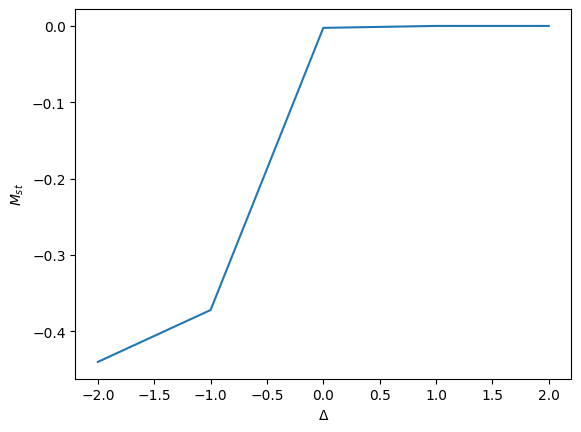

In [254]:
list1=[result_list[i]/12 for i in range(len(result_list))]
plt.plot([-2,-1,0,1,2],list1)
plt.xlabel("$\Delta$")
plt.ylabel("$M_{st}$")

#### Neares neighbour correlator computation and plotting

In [255]:
def circ_func(entanglement,optimiser,delta):
    # Define the number of qubits and the type of rotations you want to use
    num_qubits = 12
    rotation_blocks = ["rx"]
    entanglement_blocks = 'cz'
    entanglement = entanglement
    #full

    # Define the number of layers for the ansatz
    num_layers = 3

    # Create the TwoLocal ansatz circuit
    ansatz_Heisemberg = TwoLocal(
        num_qubits,
        rotation_blocks=rotation_blocks,
        entanglement_blocks=entanglement_blocks,
        entanglement=entanglement,
        reps=num_layers,
        insert_barriers=True
    )
    # ansatz_Heisemberg.decompose().draw("mpl")
    spsa = SPSA(maxiter = 100)
    slsqp = SLSQP(maxiter = 100)

    estimator = Estimator()
    seed = 50
    algorithm_globals.random_seed = seed
 
    vqe = VQE(estimator = estimator, ansatz=ansatz_Heisemberg,optimizer = optimiser)
    

    line_lattice = LineLattice(num_nodes=12, boundary_condition=BoundaryCondition.PERIODIC)

    heisenberg = HeisenbergModel(lattice=line_lattice, coupling_constants = (-1.0,-1.0,-delta),ext_magnetic_field=(0,0,0.001))

    mapper = LogarithmicMapper()
    converter = QubitConverter(mapper=mapper)
    hamiltonian = heisenberg.second_q_op()
    hamiltonian1 = converter.convert(hamiltonian)

    heisenberg_magne3 = HeisenbergModel(lattice=line_lattice, coupling_constants = (0,0,1),ext_magnetic_field=(0,0,0.001))

    mapper = LogarithmicMapper()
    converter = QubitConverter(mapper=mapper)
    magne3 = heisenberg_magne3.second_q_op()
    magne31 = converter.convert(magne3)

    result1 = vqe.compute_minimum_eigenvalue(operator = hamiltonian1, aux_operators=[magne31])

    return result1

maxiter=4000
outputFile=open("M_delta.dat","w",encoding='utf-8')
delta_list=[-2,-1,0,1,2]
entanglement_options = ["full","circular"]
optimizers = [SPSA(maxiter=maxiter),SLSQP(maxiter=maxiter),COBYLA(maxiter=maxiter)]

# We compute now the exact solution to compare the VQE with the exact solution

result_list=[]
for delta in delta_list:
    print(delta)
    result1 = circ_func(entanglement_options[1],optimizers[2],delta)
    print(result1.aux_operators_evaluated)
    result_list.append(result1.aux_operators_evaluated[0][0])

-2
[(-2.648870440572171, {})]
-1
[(-2.264818522436925, {})]
0
[(-0.902073579155534, {})]
1
[(1.6293048911754078, {})]
2
[(3.0059830461769805, {})]


Text(0, 0.5, '$C$')

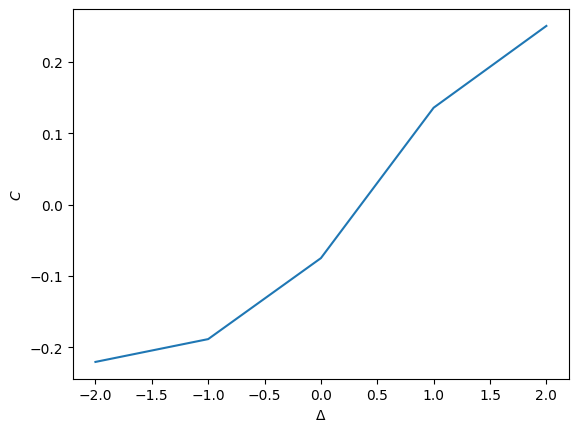

In [256]:
list1=[result_list[i]/12 for i in range(len(result_list))]
plt.plot([-2,-1,0,1,2],list1)
plt.xlabel("$\Delta$")
plt.ylabel("$C$")

_Having characterized the security system's board material, your breaching expert proceeds to hack it by driving it through the different phases at convenience._

_Congratulations, you've overcome the first challenge!_

----
_The main gate opens and you get a first glimpse of the core's control room.
Apparently, they were conducting research on cleaner nuclear energy.
A novel purpose, although it's now about to wipe us all clean._

_The core is shielded with a shell of lithium hydrate (LiH).
However, the nuclear reaction is going wild and it's destabilizing the shell.
The radiation coming from the core has heated the LiH and excited its electrons, which interferes with the diagnosis system.
If you knew the electronic structure of the material, you could bring the excited electrons down to their low-lying states through stimulated emission._

# 2. FERMIONS IN EXCITED STATES: THE LITHIUM HYDRATE MOLECULE  <a class="anchor" id="2"></a> [[↑]](#0)

_You're packing the quantum computer, when Seedis starts taking it out again.
"Alright mates, we've got plenty of lasers around.
Let's figure out the spectrum of the shell and we can surely point at it some of them to hold it together"._

> Molecular compounds are extremely valuable for our society, as they are central in material sciences and medicine.
Here, we study the electronic properties of the LiH ionic conductor.
Actually, we use different isotopes of LiH to shield and moderate nuclear reactors, but we take this little licence here :)

The goal is to study the electronic structure of the lithium hydrate (LiH) molecule.
The energies in the reactor are so high that the molecules are being distorted.
Therefore, we wish to know the dependence of the low-lying excited states with the interatomic distance. 

The particles we consider (electrons) are fermions.
These are different in nature from the qubits we have access to.
Thus, we need to map the fermionic Hamiltonian to qubits.
To give an intuition, we can relate our qubit states, $|0\rangle$ and $|1\rangle$, with the occupation of the molecule's electronic orbitals, e.g. we can mark occupied orbitals with a $|1\rangle$.
Here, consider the minimal basis set of spin orbitals STO-3G.

When we study these physical systems, we need to take into account that our molecules have a fixed number of electrons that move along the orbitals.
This means we can only consider states with a fixed amount of qubits in state $|1\rangle$, as changing orbitals will replace $|0\rangle$ by $|1\rangle$ in the destination and $|1\rangle$ by $|0\rangle$ at the origin.
For example, Li has three electrons and H has one, meaning that our states must always have four qubits in state $|1\rangle$.
Properly encoding this in our variational ansatze will be essential to find good results.

> Tip: to ease the calculations, restrict the active space by freezing the core orbitals. 
Furthermore, you can exploit the symmetries in the resulting Hamiltonian to reduce the number of qubits.
This does not look like a lot, but it'll surely help ;)

## 2.1 - Molecular spectra

To warm up, find the GS energy of the LiH molecule considering a bond distance of $2~\unicode{x212B}$.
Use a parity map to map the fermionic Hamiltonian to qubits.
Compute also the energy of the next two excited states.

Find the true values with exact diagonalization and compare them with the results obtained through VQE (the closer, the better!).
To obtain the excited states, you can use any extension of the VQE you want, e.g., variational quantum deflation [[Ref.3]](#REF)<a class="anchor" id="Ref3"></a>.

Use a suitable optimizer and a particle-preserving ansatz.

### Compute the energy of the GS and the two first excited states and compare them with the exact results.

#### General problem solver for problem 2

In [ ]:
import numpy as np

from qiskit_nature.units import DistanceUnit # Define the units of the problem
from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper # Mappers. We can experiment with them

from qiskit_nature.second_q.drivers import PySCFDriver

# from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver # Use qiskit eigensolver 

from qiskit.algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute
# from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.settings import settings 
from qiskit.opflow import TwoQubitReduction

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.eigensolvers import VQD
# from qiskit.circuit.library import TwoLocal, EfficientSU2

# from qiskit_nature.second_q.algorithms import GroundStateEigensolver, ExcitedStatesEigensolver, NumPyEigensolverFactory, QEOM
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, GroundStateEigensolver


import matplotlib.pyplot as plt

from qiskit import BasicAer, Aer


def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(["Li", "H"], [(0.0, 0.0, 0.0), (dist, 0.0, 0.0)], charge=0, multiplicity=1)

    driverM = PySCFDriver.from_molecule(molecule, basis="sto3g")

    problem = driverM.run()


    # Define Problem, Use freeze core approximation, remove orbitals.

    transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[-3,-2])

    problem = transformer.transform(problem)

    hamiltonian = problem.hamiltonian.second_q_op()

    num_particles = problem.num_particles
    num_spin_orbitals = problem.num_spatial_orbitals

    # Do two qubit reduction
    converter = QubitConverter(ParityMapper(),two_qubit_reduction=True)
    # reducer = TwoQubitReduction(num_particles)

    qubit_op = converter.convert(hamiltonian, num_particles = num_particles)
    # qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter


def exact_solver(problem, converter):
    solver = NumPyEigensolverFactory(use_default_filter_criterion=True, k = 3)
    calc = ExcitedStatesEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 2.5, 0.25)
exact_energies_ground = []
exact_energies_first = []
exact_energies_second = []
vqe_energies = []

vqd_energies_ground = []
vqd_energies_first = []
vqd_energies_second = []
optimizer = COBYLA(maxiter=100)


for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
    result = exact_solver(problem, converter)
    exact_energies_ground.append(result.total_energies[0])
    exact_energies_first.append(result.total_energies[1])
    exact_energies_second.append(result.total_energies[2])
    init_state = HartreeFock(num_spatial_orbitals = num_spin_orbitals, num_particles = num_particles, qubit_converter = converter)
    var_form = UCCSD(num_spatial_orbitals = num_spin_orbitals, num_particles = num_particles, qubit_converter = converter, initial_state=init_state)
    print('check \n')

    sampler = Sampler()
    fidelity = ComputeUncompute(sampler)

    vqd = VQD(estimator=Estimator(),fidelity = fidelity, ansatz=var_form,optimizer=optimizer, k = 3, initial_point=len(var_form.parameters)*[0.])
    vqd_calc = vqd.compute_eigenvalues(qubit_op)
    vqd_calc = problem.interpret(vqd_calc).total_energies
    vqd_energies_ground.append(vqd_calc[0])
    vqd_energies_first.append(vqd_calc[1])
    vqd_energies_second.append(vqd_calc[2])

    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQD Ground Result: {vqd_calc[0]:.5f}",
          f"VQD First Result: {vqd_calc[1]:.5f}",
          f"VQD Second Result: {vqd_calc[2]:.5f}",
          f"Exact Energy Ground: {exact_energies_ground[-1]:.5f}",
          f"Exact Energy First: {result.eigenvalues[1]:.5f}",
          f"Exact Energy Second: {result.eigenvalues[2]:.5f}")

print("All energies have been calculated")

print(exact_energies_ground, '\n')
print(exact_energies_first, '\n')
print(exact_energies_second, '\n')
print(vqd_energies_ground, '\n')
print(vqd_energies_first, '\n')
print(vqd_energies_second, '\n')

fig, ax = plt.subplots()
ax.scatter(distances, exact_energies_ground)
ax.scatter(distances, exact_energies_first)
ax.scatter(distances, exact_energies_second)
ax.scatter(distances, vqd_energies_ground)
ax.scatter(distances, vqd_energies_first)
ax.scatter(distances, vqd_energies_second)
ax.set_xlabel('Distance')
ax.set_ylabel('Energy')
ax.legend()
plt.show()

#### Values from the execution made before. From here we can extract the data needed to answer questions 2.1 and 2.2

In [257]:
import matplotlib.pyplot as plt 
import numpy as np

distances = np.arange(0.5, 2.5, 0.25)

exact_energies_ground = [-0.9874449042719773, -1.1318445978929346, -1.1742365493173832, -1.1495902879732611, -1.1001883332861144, -1.0444964496404539, -0.9904135798051014, -0.9416125658192505]
exact_energies_first = [-0.9260866256525935, -1.0198113419515595, -1.034024857290718, -1.0035360042228647, -0.9616732839989912, -0.9200075698042087, -0.8818676540989077, -0.8478670389184528] 
exact_energies_second = [-0.8467307320247985, -0.9535852123992326, -0.9753906238873573, -0.948402073041086, -0.9087039493717713, -0.8692907695608154, -0.8341291665008773, -0.8041042759131822] 
vqd_energies_ground = [-0.9266253848393236, -1.0222054495329664, -1.031676395195999, -1.007441461493816, -0.9656445924975675, -0.9243251148233148, -0.8879351718646614, -0.853567099852794]
vqd_energies_first = [-0.9307645079916412, -1.0230573417432087, -1.03562231689944, -0.8738408309493575, -0.953881566430225, -0.8447762823385514, -0.5972119475846395, -0.8452506400139507] 
vqd_energies_second = [-0.6672402500011083, -0.6173801431061781, -0.5729367463469265, -0.49246731912535185, -0.4973589540789923, -1.037245350566055, -0.7042288834296814, -0.7871738325867372] 


#### 2.1 - Answer

In [259]:
distance_2_energy = exact_energies_ground[-3]
first_excited_distance_2_energy = exact_energies_first[-3]
second_excited_distance_2_energy = exact_energies_second[-3]
print(f"Exact ground state energy at distance 2: {distance_2_energy:.5f}, first excited state energy at distance 2: {first_excited_distance_2_energy:.5f}, second excited state energy at distance 2: {second_excited_distance_2_energy:.5f}")

Exact ground state energy at distance 2: -1.04450, first excited state energy at distance 2: -0.92001, second excited state energy at distance 2: -0.86929


## 2.2 - Spectrum as function of the bond length

Compute the the GS and the first two excited states energies as function of the bond length.
Consider bond lengths in a range of $0.5~\unicode{x212B}$ and $2.5~\unicode{x212B}$ in intervals of $0.25~\unicode{x212B}$.

Compare the exact energies with those obtained through variational methods.

### Compute the energy of the GS and the next two excited states as function of the bond length. Can you (roughly) identify a candidate for the equilibrium bond length of the molecule?

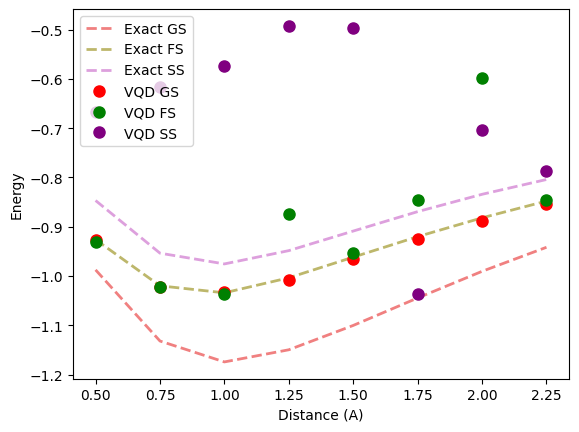

In [239]:
fig, ax = plt.subplots()
ax.set_xlabel('Distance (A)')
ax.set_ylabel('Energy')
ax.plot(distances,exact_energies_ground,linestyle="--",color='lightcoral',linewidth=2,label='Exact GS' )
ax.plot(distances,exact_energies_first,linestyle="--",color='darkkhaki',linewidth=2,label='Exact FS' )
ax.plot(distances,exact_energies_second,linestyle="--",color='plum',linewidth=2,label='Exact SS' )
ax.plot(distances,vqd_energies_ground,linestyle="",marker="o",markersize=8,color='red',linewidth=2,label='VQD GS' )
ax.plot(distances,vqd_energies_first,linestyle="",marker="o",markersize=8,color='green',linewidth=2,label='VQD FS' )
ax.plot(distances,vqd_energies_second,linestyle="",marker="o",markersize=8,color='purple',linewidth=2,label='VQD SS' )
ax.legend(loc='best')
plt.show()

With the exact *GS*, we can se that the bonding length is arround $d=1.00\AA$.

Something that we realised is that the *GS* calculated with the `VQE` is converging into the first excited state calculated with the exact solver. This was a problem due to the initialization of the state: when we initialized the initial state with all $|0\rangle$, the output is the follows:

![P2.2](P2.2.jpeg)

We can see that now the *GS* is pretty much the exact solution but the other one diverges. This could be due to a lack of steps

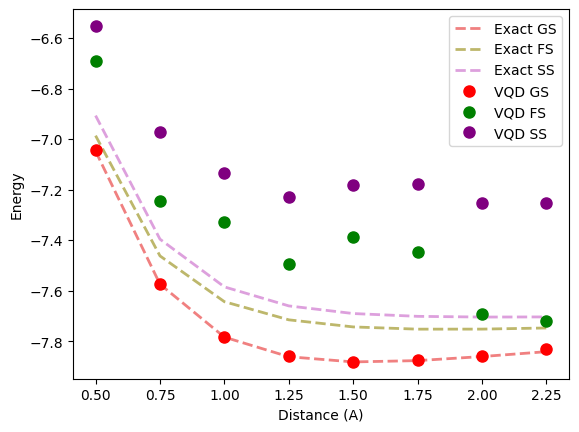

In [260]:
import matplotlib.pyplot as plt 
import numpy as np

distances = np.arange(0.5, 2.5, 0.25)

exact_energies_ground = [-7.047909879925468, -7.574578993822753, -7.784021320447713, -7.861611916092615, -7.882139960235194, -7.876947173757031, -7.860828258230606, -7.841540566608273] 
exact_energies_first = [-6.986551601306084, -7.462545737881378, -7.643809628421047, -7.715557632342218, -7.74362491094807, -7.752458293920787, -7.752282332524413, -7.747795039707476] 
exact_energies_second = [-6.907195707678291, -7.396319608329051, -7.585175395017687, -7.66042370116044, -7.690655576320849, -7.701741493677394, -7.704543844926382, -7.704032276702206] 
vqd_energies_ground = [-7.043375710605387, -7.57296109044097, -7.78231709428728, -7.859890184941467, -7.88088821233849, -7.873994457196799, -7.858255684947045, -7.83183987414494] 
vqd_energies_first = [-6.69300365266764, -7.244215055814696, -7.328215703307154, -7.494466329471681, -7.38726303780262, -7.446412442034331, -7.691840129837971, -7.722004051946655]
vqd_energies_second = [-6.55225422382804, -6.972128556899591, -7.134050985416914, -7.230095591418712, -7.182299651998236, -7.177377423257866, -7.25166012093303, -7.2533833253824405] 


fig, ax = plt.subplots()
ax.set_xlabel('Distance (A)')
ax.set_ylabel('Energy')
ax.plot(distances,exact_energies_ground,linestyle="--",color='lightcoral',linewidth=2,label='Exact GS' )
ax.plot(distances,exact_energies_first,linestyle="--",color='darkkhaki',linewidth=2,label='Exact FS' )
ax.plot(distances,exact_energies_second,linestyle="--",color='plum',linewidth=2,label='Exact SS' )
ax.plot(distances,vqd_energies_ground,linestyle="",marker="o",markersize=8,color='red',linewidth=2,label='VQD GS' )
ax.plot(distances,vqd_energies_first,linestyle="",marker="o",markersize=8,color='green',linewidth=2,label='VQD FS' )
ax.plot(distances,vqd_energies_second,linestyle="",marker="o",markersize=8,color='purple',linewidth=2,label='VQD SS' )
ax.legend(loc='best')
plt.show()

## 2.3 - Imperfect devices

In the current noisy intermediate-scale quantum (NISQ) devices, the operations are imperfect and the errors accumulate along the execution of the circuit.
In particular, two-qubit operations, such as the CNOT, have the highest errors.

Here, we consider a more realistic scenario in which we simulate noisy two-qubit gates.
Create a noise model considering an error rate of $0.02$ in CNOT operations.
See the example code below:

```python
from qiskit_aer.noise import NoiseModel, depolarizing_error
noise_model = NoiseModel()
error = depolarizing_error(0.02, 2)
noise_model.add_all_qubit_quantum_error(error, ['cx'])
```

Compute the GS and first excited state energies as function of the bond length with the noisy simulation and compare it with the exact values.

Large circuits with many entangling gates will accumulate many errors, damaging the performance.
Try different ansatze to find the best trade-off between expressivity and errors (even if they do not preserve the particle number).
You can also use other Hamiltonian mappings that may be more convenient for the task.

Report the best results you find and briefly describe your findings (what worked best and what did not).

### Compute the GS and first excited state energies as function of the bond length in the noisy simulation.

In [ ]:
import numpy as np

from qiskit_nature.units import DistanceUnit # Define the units of the problem
from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper # Mappers. We can experiment with them

from qiskit_nature.second_q.drivers import PySCFDriver

# from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver # Use qiskit eigensolver 

from qiskit.algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute
# from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.settings import settings 
from qiskit.opflow import TwoQubitReduction

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.eigensolvers import VQD
# from qiskit.circuit.library import TwoLocal, EfficientSU2

# from qiskit_nature.second_q.algorithms import GroundStateEigensolver, ExcitedStatesEigensolver, NumPyEigensolverFactory, QEOM
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, GroundStateEigensolver

# Imports for adding noise 

from qiskit.providers.fake_provider import FakeVigo
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.circuit.library import EfficientSU2

from qiskit.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA


import matplotlib.pyplot as plt

from qiskit import BasicAer, Aer


seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)


def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(["Li", "H"], [(0.0, 0.0, 0.0), (dist, 0.0, 0.0)], charge=0, multiplicity=1)

    driverM = PySCFDriver.from_molecule(molecule, basis="sto3g")

    problem = driverM.run()


    # Define Problem, Use freeze core approximation, remove orbitals.

    transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[-3,-2])

    problem = transformer.transform(problem)

    hamiltonian = problem.hamiltonian.second_q_op()

    num_particles = problem.num_particles
    num_spin_orbitals = problem.num_spatial_orbitals

    # Do two qubit reduction
    converter = QubitConverter(ParityMapper(),two_qubit_reduction=True)
    # reducer = TwoQubitReduction(num_particles)

    qubit_op = converter.convert(hamiltonian, num_particles = num_particles)
    # qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter


def exact_solver(problem, converter):
    solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
    calc = ExcitedStatesEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = Aer.get_backend('aer_simulator')
device = FakeVigo()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
print(noise_model)

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)


distance = [1.6] 
exact_energies_ground = []
exact_energies_first = []
exact_energies_second = []


vqd_noisy_ground = []
vqd_noisy_first = []

optimizer = COBYLA(maxiter=5)

for dist in distance:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
    print(converter.num_particles)
    result = exact_solver(problem, converter)
    exact_energies_ground.append(result.groundenergy.real)
    exact_energies_first.append(result.eigenvalues[1])
    exact_energies_second.append(result.eigenvalues[2])

    sampler = Sampler()
    fidelity = ComputeUncompute(sampler)
    
    # init_state = HartreeFock(num_spatial_orbitals = num_spin_orbitals, num_particles = num_particles, qubit_converter = converter)
    # var_form = UCCSD(num_spatial_orbitals = num_spin_orbitals, num_particles = num_particles, qubit_converter = converter, initial_state=init_state)
    # vqd_noisy = VQD(estimator = noisy_estimator, fidelity = fidelity, ansatz = var_form, optimizer=optimizer, k = 2)
    # vqd_calc_noisy = vqd_noisy.compute_eigenvalues(qubit_op).optimal_values
    # vqd_noisy_ground.append(vqd_calc_noisy[0])
    # vqd_noisy_first.append(vqd_calc_noisy[1])

    iterations = 125
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    spsa = SPSA(maxiter=iterations)

    vqe = VQE(noiseless_estimator, ansatz, optimizer=spsa)
    result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
    result = problem.interpret(result).total_energies


print("All energies have been calculated")



print(result, '\n')
print(exact_energies_ground)

Noisy Ground State: -8.51901298

Exact Ground State: -7.88213996

_Knowing the electronic properties of the shell, you've managed to stabilize it and cool it a bit in the process.
This has given you some time to work and find a solution._

_We're all slightly less likely to die. Great!_

----

_With the stabilized shell, you can finally run a scanner and obtain a clear diagnosis of the core.
It appears that someone must've momentarily slept on the core moderators, producing a high temperature spike that has caused the LiH from the shell to release hydrogen gas (H$_2$)._

_This has ignited a side fusion reaction of the hydrogen, that further raises the temperature, releasing more H$_2$ to the mixture.
NOT GOOD!
This'll get out of control in a moment.
You must deploy the H collectors (if they work) before this gets out of control!_

_With the apparent mess, the collector memories have been reset.
Given the situation, you feel lucky to even find some functional collectors._ 

# 3. MASTER THE QUANTUM SIMULATION SHENANIGANS  <a class="anchor" id="3"></a> [[↑]](#0)

_Seedis is on a rampage: "Let's go bois and gals, these collectors won't get fixed by themselves! We just need to load the H$_2$ data to stop the retroalimentation loop."_

> It's time to test the power of a real quantum computer.
In this task you will use an actual quantum computer to find the ground state of the H$_2$ molecule. 

Using one of the quantum computers from [IBM Quantum](https://quantum-computing.ibm.com/), find the GS energy of the hydrogen molecule H$_2$ for a bond distance of $0.735~\unicode{x212B}$.
Use all the tools at your disposal to obtain the best possible result and try to make the most efficient use of resources through [Qiskit runtime](https://quantum-computing.ibm.com/lab/docs/iql/runtime/).

We recommend looking carefully at both runtime (the faster, the more you can experiment) and error sources (self-explanatory!).
Here, we provide a few ideas to explore. However, you are not bound to implement any of these, you're completely free to do whatever you want to improve the simulation.

Consider:
- Looking into the hardware architecture to identify the best qubits to use
- Calibrate the qubits with [Qiskit Pulse](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html)
- Tailor the ansatz to the hardware
- Implement an adaptive algorithm to reduce the ansatz size
- Implement error mitigation techniques like [measurement error mitigation](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html), [randomized compiling](https://qiskit.org/documentation/stable/0.32/stubs/qiskit.ignis.verification.QOTP.html), and [others](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/Error-Suppression-and-Error-Mitigation.html)
- Parallelize operations and measurements
- Explore [dynamic circuit](https://quantum-computing.ibm.com/services/programs/docs/runtime/manage/systems/dynamic-circuits/Introduction-To-Dynamic-Circuits) techniques
- Explore more advanced optimization schemes (e.g., [Quantum Natural SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.QNSPSA.html))

In [ ]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [ ]:
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

import warnings
warnings.filterwarnings("ignore")

import math
pi=math.pi

In [ ]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()


hub = "ibm-q-community"
group = "digiq-icfo-hack"
project = "main"

backend_name = "ibmq_jakarta" # 7 qubits
#backend_name = "ibmq_guadalupe	" # 16 qubits

backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

shots: int = 1024 # Number of shots to run each circuit for

print(len(backend.properties().qubits))

In [ ]:
from qiskit import transpile
#-------

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
# service = QiskitRuntimeService(channel="ibm_quantum", token="")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result(

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import SPSA
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.algorithms import NumPyEigensolverFactory, ExcitedStatesEigensolver

from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt



molecule = MoleculeInfo(["Li","H"],[(0.0,0.0,0.0), (0.735, 0.0, 0.0)], charge = 0, multiplicity = 1)

driverM = PySCFDriver.from_molecule(molecule, basis = 'sto3g')

problem = driverM.run()

transformer = FreezeCoreTransformer(freeze_core=True)

problem = transformer.transform(problem)

hamiltonian = problem.hamiltonian.second_q_op()

num_particles = problem.num_particles
num_spin_orbitals = problem.num_spatial_orbitals

converter = QubitConverter(ParityMapper(),two_qubit_reduction=True)

qubit_op = converter.convert(hamiltonian, num_particles = num_particles)


solver = NumPyEigensolverFactory(use_default_filter_criterion=True, k = 3)
calc = ExcitedStatesEigensolver(converter, solver)
result = calc.solve(problem)
print(total_energies)

optimizer = COBYLA(maxiter=100)



# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.get_backend("ibmq_qasm_simulator")



# Use RealAmplitude circuit to create trial states

ansatz = RealAmplitudes(num_qubits=2, reps = 2)

# Search for better states using SPSA algorithm

np.random.seed(6)
initial_point = np.random.uniform(-np.pi, np.pi, 12)

# Create an object to store intermediate results 

@dataclass
class VQELog:
    values: list
    parameters: list
    
    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~350", end="\r", flush=True)
    
log = VQELog([],  [])



# Main calculation
with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 3
    

    vqe = VQE(
        Estimator(session=session, options=options),
        ansatz,
        optimizer,
        callback=log.update,
        initial_point=initial_point,
    )
    result = vqe.compute_minimum_eigenvalue(operator = qubit_op)
    result = problem.interpret(result).total_energies
    print("Experiment complete.".ljust(30))
    print(f"Raw result: {result}")

    if "simulator" not in backend:
        # Run once with ZNE error mitigation
        options.resilience_level = 2
        vqe = VQE(
            Estimator(session=session, options=options),
            ansatz,
            SPSA(1),
            initial_point=result.optimal_point,
        )
        result = vqe.compute_minimum_eigenvalue(operator = qubit_op)
        result = problem.interpret(result).total_energies
        print("Experiment complete.".ljust(30))
        print(f"Raw result: {result}")

        

plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE")
plt.axhline(y=real_solution.groundenergy, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()
        
        

        
#-----
# initial_layout=[0,1,2,3,4] # optional



#job = backend.run(qc_transpiled, shots=1024, job_tags=["team_name", "bcn_hackathon"])

#counts = job.result().get_counts()

## Bonus: an extra atom

If you consider that you have obtained a competitive result for H$_2$, you can tackle the H$_3^+$ molecule. It has the same number of electrons, but you will have to consider more orbitals (which requires more qubits).

The three hydrogen atoms form an equilater triangle with bond length $0.986~\unicode{x212B}$.

In [265]:
# Function to draw a Christmas tree with a given height
def draw_tree(height):
  # Loop through each row of the tree
  for i in range(1, height + 1):
    # Print the spaces before the asterisks on each row
    for j in range(height - i):
      print(" ", end="")
    # Print the asterisks on each row
    for j in range(2 * i - 1):
      print("*", end="")
    # Move to the next line
    print()
# Call the function to draw a tree with a height of 5
draw_tree(25)

                        *
                       ***
                      *****
                     *******
                    *********
                   ***********
                  *************
                 ***************
                *****************
               *******************
              *********************
             ***********************
            *************************
           ***************************
          *****************************
         *******************************
        *********************************
       ***********************************
      *************************************
     ***************************************
    *****************************************
   *******************************************
  *********************************************
 ***********************************************
*************************************************


In [ ]:
.*(@@@@%/,                                   
                          @@@@@@@@@@@@&%%&@@@@@@@@@@@@/                         
                    .@@@@@@.  ,@@@            /@@@   /@@@@@@                    
                 @@@@@           @@@@@@@@@@@@@@(          .@@@@&                
              @@@@     @@@@@.,*///((##%%&&@@@@@@@@@(,         (@@@&             
           @@@@  ..,,,@@@@@@@*,.                 ./%@@@@@@@@@@@@ (@@@           
         @@@@*,     @@@@@.                                  #@@@@@@@        
       %@@@/               @@#                                       @@@@       
      @@@                   &@@                                        ,@@@     
    /@@@&                    .@@(                                      %@@@@    
   #@@. @@@@,                  @@@                                  &@@@% @@@   
  #@@.     /@@@@@@%             *@@(,,,,,,,,,,,..            *@@@@@@@      @@@  
  @@%          ,@&@@@@@@@@@@@@@@@@@@@/.,,/(%&@@@@@@@@@@@@@@@&%@,          @@& 
 @@@    @@@@@@@@*              .(%@@@@@@@@@@%(.               /@@@@@@@&   ,@@.
 @@@@@@@%                            @@&                                @@@@@@@&
.@@@%                                 &@@                                   @@@@
,@@.                                    @@&                                  #@@
 @@@@                                    @@@                                @@@@
 @@&@@@@@.                                .@@/                         &@@@@%@@&
 &@@    (@@@@@@@@*          .#%###((////**@@@,,,..          ,@@@@@@@@@    *@@ 
  @@&           (@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@%            @@% 
  @@/     @@@@@@(                .,,///**,.  @@@             *////((     @@@  
   /@@*/@@@%                                    %@@                  #### @@@   
    ,@@@@                                         @@%                  .%@@@    
      @@@                                          %@@                 #@@&     
       /@@@@.                                       .@@/            #@@@@       
         (@@@@@@@@#                                   @@@@@  ,@@@@@@@@@         
           ,@@@( .@@@@@@@@@@@@@@@@#/,....,,(&@@@@@@@@@@@@@@@*  @@@@           
              @@@@(            .(@@@@@@@@@@@@#,     .@@@@   @@@@,             
                 %@@@@/       .&%%%          ,%%%&        @@@@@                 
                     (@@@@@@  @@@              .@@/ *@@@@@@                     
                           @@@@@@@@@@@@@@@@@@@@@@@@@@(

_You upload the simulation results to the few functional collectors.
With more faith than expectations, you deploy them to clear the core chamber hoping they will collect enough H$_2$ before they fry._

_Alea iacta est._

_This gives you a brief moment to think about the possible outcomes.
It does not look good, and you look into your teamates eyes.
You feel pure respect and joy to be in such an amazing unit._

_The last collector is down.
Your heart stops for a moment, right before you see the temperature starting to drop.
You did it!
Well, technically you still need to stabilize the core, but the biggest threat has been neutralized.
The rest is just a rutinary protocol._

_Congratulations!
You should all be proud of your hard work during this intense weekend.
It surely was an entertaining crisis to handle!_

## REFERENCES <a class="anchor" id="REF"></a> [[↑]](#0)

[1] Franchini, Fabio. An introduction to integrable techniques for one-dimensional quantum systems. Vol. 940. Cham: Springer International Publishing, 2017. ([url](https://arxiv.org/abs/1609.02100))

[2] Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246. ([url](https://arxiv.org/abs/1704.05018))

[3] Higgott, Oscar, Daochen Wang, and Stephen Brierley. "Variational quantum computation of excited states." Quantum 3 (2019): 156. ([url](https://quantum-journal.org/papers/q-2019-07-01-156/))